In [294]:
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time

sys.path.append('../utils')
import data_paths
from excel_calendar import Calendar
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions
from lmfit.models import SkewedGaussianModel, Model, gaussian

# Import Data

In [24]:
# import speed and volume data from traffic counting stations
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links_v2.gpkg')

# raw speed and counting data
cnt_lhm = pd.read_parquet(data_paths.MST_COUNTING_PATH + 'preprocessed_lhm_counting_data.parquet')

# only detectors that are assigned to a road link in the visum model
cnt_lhm = cnt_lhm[cnt_lhm['road_link_id'].isin(visum_links['road_link_id'].unique())] 
cnt_lhm_2019 = cnt_lhm[cnt_lhm['date'].between('2019-01-01','2019-12-31')] # reduce to 2019 data

# import traffic cycles
cycles = TrafficCounts()

# import hbefa emission factors
hbefa = HbefaHotEmissions()

# initialize calendar
cal = Calendar()

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS


# Prepare dataframe with detector information

In [25]:
# prepare dataframe with information about the detectors (from VISUM model)
_det = cnt_lhm_2019.set_index('detector_id')['road_link_id'].to_dict()
detector_information = pd.DataFrame.from_dict(_det, orient='index', columns=['road_link_id'])
detector_information['road_type'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['road_type'].to_dict())
detector_information['hour_capacity'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['hour_capacity'].to_dict())
detector_information['lanes'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['lanes'].to_dict())
detector_information['hbefa_speed'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['hbefa_speed'].to_dict())
detector_information['speed'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['speed'].to_dict())
detector_information['hbefa_gradient'] = detector_information['road_link_id'].map(visum_links.set_index('road_link_id')['hbefa_gradient'].to_dict())

# add ffs information from table S3-2 hbefa 2015
# normalbreiter Fahrstreifen -> f_FS = 1
# überbreiter Fahrstreifen -> f_FS = 0.7 (geringe Erschiesungsintensität), 0.8 (hohe Erschliesungsintensität)
# zwei markierte Fahrstreifen -> f_FSA = 0.5 (anbaufrei), 0.6 (geringe Erschiesungsintensität), 0.7 (hohe Erschliesungsintensität)
detector_information['f_FS'] = 1.
detector_information.loc[detector_information[detector_information['lanes']>=2].index, 'f_FS'] = 0.7 #insbesondere mittlerer Ring
detector_information.loc[detector_information[(detector_information['lanes']<2) &\
    (detector_information['hour_capacity']> 1000)].index, 'f_FS'] = 0.8 #Expertenschätzung: Straßen mit hoher Kapazität besitzen überbreite Fahrstreifen.

detector_information.head()

,road_link_id,road_type,hour_capacity,lanes,hbefa_speed,speed,hbefa_gradient,f_FS
4010011,80645.0,TrunkRoad/Primary-City,5400,3,50,50,0%,0.7
4010012,80645.0,TrunkRoad/Primary-City,5400,3,50,50,0%,0.7
4010013,80645.0,TrunkRoad/Primary-City,5400,3,50,50,0%,0.7
4010014,80645.0,TrunkRoad/Primary-City,5400,3,50,50,0%,0.7
4010021,80645.0,TrunkRoad/Primary-City,5400,3,50,50,0%,0.7


# Prepare speed and volume dataframe

In [26]:
#calculate total traffic volume and convert in personal car units
pkw_e_scaling_factors = hbefa.car_unit_factors
hour_value_colums = [str(i) for i in list(range(1,25))] # hour value columns have string column names from 1 to 25

cnt_lhm_scaled = cnt_lhm_2019[(cnt_lhm_2019['metric']=='volume') &
                              (cnt_lhm_2019['vehicle_class']!='SUM')].copy() # take all traffic volume values besides the SUM
cnt_lhm_scaled['pcu_factor'] = cnt_lhm_scaled['vehicle_class'].map(pkw_e_scaling_factors)
cnt_lhm_scaled[hour_value_colums] = cnt_lhm_scaled[hour_value_colums]\
    .mul(cnt_lhm_scaled['pcu_factor'], axis ='index')
    
total_volume = cnt_lhm_scaled.groupby(['detector_id',
                                       'date'])[hour_value_colums].sum(numeric_only = True)
vehicle_volume = cnt_lhm_2019[(cnt_lhm_2019['metric']=='volume') &
                              (cnt_lhm_2019['vehicle_class']!='SUM')].copy()
vehicle_volume = vehicle_volume.groupby(['detector_id',
                                         'date',
                                         'vehicle_class'])[hour_value_colums].sum(numeric_only = True)

total_volume = total_volume.reset_index()
total_volume.insert(2, column = 'vehicle_class', value ='SUM[PCU]')

volumes = pd.concat([total_volume, vehicle_volume.reset_index()], axis = 0)
volumes = volumes.melt(id_vars=['date',
                                'detector_id',
                                'vehicle_class'], value_vars = hour_value_colums)
volumes = volumes.pivot(index = ['detector_id', 'date', 'variable'],
                        columns = 'vehicle_class', 
                        values = 'value')

# prepare speeds dataset
hour_value_colums.extend(['detector_id', 'date'])
speeds = cnt_lhm_2019[(cnt_lhm_2019['metric']=='speed') &
                      (cnt_lhm_2019['vehicle_class']=='PC')][hour_value_colums] # take speed values of PC as indicators

# combine speed and volume dataset
speeds = speeds.melt(id_vars=['date', 'detector_id'])
speeds = speeds.set_index(['detector_id', 'date', 'variable'])
speeds.rename(columns = {'value':'speed_true'}, inplace = True)

_detector_dat = pd.concat([volumes, speeds], axis=1)

# reduce to useful data
_detector_dat = _detector_dat[(_detector_dat['speed_true']>0)]
_detector_dat.reset_index(inplace = True)

# combine date and time colume to a timestamp
_detector_dat['timestamp'] = _detector_dat.apply(lambda row: pd.Timestamp.combine(row['date'],
                                                                                time(int(row['variable'])-1)),
                                               axis =1)
_detector_dat.drop(['date', 'variable'], inplace =True, axis = 'columns')
_detector_dat.head()

,detector_id,BUS,HGV,LCV,MOT,PC,SUM[PCU],speed_true,timestamp
0,4010011,0.0,2.0,3.0,0.0,70.0,78.00,48.0,2019-01-02 23:00:00
1,4010011,0.0,2.0,1.0,0.0,37.0,43.00,48.0,2019-01-03 00:00:00
2,4010011,0.0,19.0,27.0,0.0,245.0,319.50,48.0,2019-01-03 09:00:00
3,4010011,1.0,18.0,36.0,0.0,268.0,350.75,47.0,2019-01-03 10:00:00
4,4010011,0.0,16.0,15.0,0.0,255.0,310.00,47.0,2019-01-03 11:00:00


# Merge Detector Data and Calculate LOS classes

In [27]:
hbefa_road_abbreviations = hbefa.hbefa_road_abbreviations
hbefa_los_classes = hbefa.los_hbefa_mapping

def get_los_class_hbs(density, speed):
    los_density_thres_50kmh = {7:'A',
                               14:'B',
                               23:'C',
                               34:'D',
                               45:'E'}
    
    los_density_thres_70kmh = {6:'A',
                               12:'B',
                               20:'C',
                               30:'D',
                               40:'E'}
    if speed <=60: 
        for th, los in los_density_thres_50kmh.items(): 
            if th > density: 
                return los
        return 'F'
    elif speed > 60: 
        for th, los in los_density_thres_70kmh.items(): 
            if th > density: 
                return los
        return 'F'

def get_hbefa_los_class(los_class: str,
                        road_type:str,
                        hbefa_speed:int) -> str:
    praeamble  = "URB"
    los = f'{praeamble}/{hbefa_road_abbreviations[road_type]}/{str(hbefa_speed)}/{hbefa_los_classes[los_class]}'
    return los

detector_dat = _detector_dat.merge(detector_information, left_on='detector_id', right_index=True)
detector_dat['density'] = detector_dat['SUM[PCU]'] / detector_dat['speed_true']
detector_dat['density_scaled'] = detector_dat['density'] * detector_dat['f_FS']
detector_dat['LOS_hbs'] = detector_dat.apply(lambda row: get_los_class_hbs(row['density_scaled'],
                                                                     row['speed']), axis = 1)
detector_dat['LOS_hbefa'] = detector_dat.apply(lambda row: get_hbefa_los_class(row['LOS_hbs'],
                                                                         row['road_type'],
                                                                         row['hbefa_speed']), axis = 1)
detector_dat.head()

,detector_id,BUS,HGV,LCV,MOT,PC,SUM[PCU],speed_true,timestamp,road_link_id,...,hour_capacity,lanes,hbefa_speed,speed,hbefa_gradient,f_FS,density,density_scaled,LOS_hbs,LOS_hbefa
0,4010011,0.0,2.0,3.0,0.0,70.0,78.00,48.0,2019-01-02 23:00:00,80645.0,...,5400,3,50,50,0%,0.7,1.625000,1.137500,A,URB/Trunk-City/50/Freeflow
1,4010011,0.0,2.0,1.0,0.0,37.0,43.00,48.0,2019-01-03 00:00:00,80645.0,...,5400,3,50,50,0%,0.7,0.895833,0.627083,A,URB/Trunk-City/50/Freeflow
2,4010011,0.0,19.0,27.0,0.0,245.0,319.50,48.0,2019-01-03 09:00:00,80645.0,...,5400,3,50,50,0%,0.7,6.656250,4.659375,A,URB/Trunk-City/50/Freeflow
3,4010011,1.0,18.0,36.0,0.0,268.0,350.75,47.0,2019-01-03 10:00:00,80645.0,...,5400,3,50,50,0%,0.7,7.462766,5.223936,A,URB/Trunk-City/50/Freeflow
4,4010011,0.0,16.0,15.0,0.0,255.0,310.00,47.0,2019-01-03 11:00:00,80645.0,...,5400,3,50,50,0%,0.7,6.595745,4.617021,A,URB/Trunk-City/50/Freeflow


# Calculate emission for each detector

In [28]:
def calculate_emissions(vehicle_class,
                        vehicle_volume,
                        los_class,
                        hbefa_gradient, 
                        component):
    try:
        ef = hbefa.ef_dict[vehicle_class]['EFA_weighted']\
            [2019, los_class, hbefa_gradient, component]
        return vehicle_volume * ef
    except:
        return np.nan
                                                                                       
for c in hbefa.components: 
    for v in hbefa.vehicle_classes:
        detector_dat[f'{c}_{v}'] = detector_dat.apply(lambda row: calculate_emissions(vehicle_class = v,
                                                                                      vehicle_volume = row[v],
                                                                                      los_class = row['LOS_hbefa'],
                                                                                      hbefa_gradient= row['hbefa_gradient'],
                                                                                      component= c), axis = 1)

# Save detector emission calculation to file

In [29]:
filename = data_paths.COUNTING_PATH + 'detector_emission.feather'
detector_dat.to_feather(filename)

# read detector data from feather
#detector_dat = pd.read_feather(filename)

# now calculate the same using the model

In [30]:
def process_hourly_emissions(date: str,
                            visum_dict:dict,
                            cycles_obj:TrafficCounts,
                            hbefa_obj:HbefaHotEmissions,
                            ):
    try:  
        # get scaling factors for the day
        diurnal_cycles = cycles_obj.get_hourly_scaling_factors(date=date)
        vehicle_shares = cycles_obj.get_vehicle_share(date=date).to_dict()
        daily_scaling = cycles_obj.get_daily_scaling_factors(date=date).to_dict()

        em_sum_dict = dict() # initialize result dict
        
        # loop over visum model
        for row in visum_dict:
            
            # relevant information from the visum model
            dtv_visum = row['dtv_SUM']
            hgv_corr = row['hgv_corr']
            lcv_corr = row['lcv_corr']
            scaling_road_type = row['scaling_road_type']
            
            # get vehicle shares from counting data
            hgv_share = vehicle_shares['HGV'][scaling_road_type]
            lcv_share = vehicle_shares['LCV'][scaling_road_type]
            pc_share = vehicle_shares['PC'][scaling_road_type]
            mot_share = vehicle_shares['MOT'][scaling_road_type]
            bus_share = vehicle_shares['BUS'][scaling_road_type]
            
            # calculate vehicle share correction factor
            k = (1- (hgv_corr * hgv_share)- (lcv_corr * lcv_share)) / (1 - hgv_share - lcv_share)
            
            # calculate vehicle counts and apply vehicle share correction factor
            dtv = dict()
            dtv_day = dtv_visum * daily_scaling[scaling_road_type]
            dtv.update({'HGV' : (dtv_day * hgv_share * hgv_corr)})
            dtv.update({'LCV' : (dtv_day * lcv_share * lcv_corr)})
            dtv.update({'PC' : (dtv_day * pc_share * k)})
            dtv.update({'MOT' : (dtv_day * mot_share * k)})
            dtv.update({'BUS' : (dtv_day * bus_share * k)})
            
            # calculate emissions on the respective road link
            em = hbefa_obj.calculate_emissions_hourly(dtv_vehicle = dtv,
                                                     diurnal_cycle_vehicle = diurnal_cycles,
                                                     road_type = row['road_type'], 
                                                     hbefa_gradient = row['hbefa_gradient'], 
                                                     hbefa_speed = row['hbefa_speed'],
                                                     hour_capacity = row['hour_capacity'], 
                                                     year = 2019)
            
            em_sum_dict.update({row['index']:em}) # add emmissions to emission dict
        return em_sum_dict
    except:
        return np.nan

In [186]:
road_links_with_detectors = detector_dat['road_link_id'].unique()
visum_reduced = visum_links[visum_links['road_link_id'].isin(road_links_with_detectors)].copy()
visum_reduced = visum_reduced.reset_index(drop=True).reset_index()

final_emissions = list()

for day in pd.date_range(start='2019-01-01', end= '2019-12-31', freq = 'd'): # for all days in 2019
    
    em_dict = process_hourly_emissions(day.strftime('%Y-%m-%d'),
                                        visum_reduced.to_dict('records'),
                                        cycles,
                                        hbefa)
    
    df_temp = pd.DataFrame()
    for road_link_index, item in em_dict.items():
        
        data = pd.DataFrame(pd.Series(item).reset_index())
        data.rename(columns = {'level_0':'vehicle_class',
                               'level_1':'component',
                               'level_2':'hour', 
                               0:'emission'},
                    inplace = True)
        data['date'] = day
        data['road_link_index'] = road_link_index
        df_temp = pd.concat([df_temp, data], axis = 0)
    final_emissions.append(df_temp)
model_dat = pd.concat(final_emissions)
model_dat['road_link_id'] = model_dat['road_link_index'].map(visum_reduced['road_link_id'].to_dict())
model_dat['timestamp'] = model_dat.apply(lambda row: pd.Timestamp.combine(row['date'],
                                                                          time(row['hour'])), axis = 1)

In [187]:
# serialize table
model_dat_long = model_dat.groupby(['vehicle_class',
                             'timestamp',
                             'road_link_id',
                             'component'])['emission'].sum().reset_index()

model_dat_long = model_dat_long.pivot(index = ['vehicle_class', 'timestamp', 'road_link_id'],
                                      columns=['component'], values = 'emission')

model_dat_long.head()

component                              BC (exhaust)       CH4        CO  \
vehicle_class timestamp  road_link_id                                     
BUS           2019-01-01 38                0.034622  0.002287  2.106941   
                         72                0.053651  0.003560  3.199460   
                         419               0.006270  0.000429  0.364995   
                         810               0.007420  0.000489  0.471738   
                         1068              0.008559  0.000564  0.544153   

component                                CO2(rep)  CO2(total)        CO2e  \
vehicle_class timestamp  road_link_id                                       
BUS           2019-01-01 38            587.790445  620.044805  607.752045   
                         72            881.490255  929.861075  913.369361   
                         419           110.810575  116.891194  113.579953   
                         810           153.943980  162.391506  156.688097   
                         1068          177.575562  187.319849  180.740922   

component                                   NO2       NOx        PM  
vehicle_class timestamp  road_link_id                                
BUS           2019-01-01 38            0.454355  4.617598  0.055892  
                         72            0.706390  7.137619  0.086573  
                         419           0.109221  1.004717  0.010236  
                         810           0.107083  1.108525  0.012155  
                         1068          0.123521  1.278692  0.014021

# Caclulate uncertainty

In [413]:
# plot timeseries (detector vs. model)
component = 'CO2(rep)'
vehicle = 'PC'

df = pd.read_parquet(data_paths.COUNTING_PATH + 'counting_data_combined.parquet')
valid_road_links = df[df['valid']]['road_link_id'].unique()

reference_df = detector_dat.groupby(['road_link_id',
                                'timestamp'])[f'{component}_{vehicle}'].sum() #aggregate for each road link and timestamp

model_df = model_dat_long.loc[vehicle].reset_index().set_index(['road_link_id', 'timestamp'])[component]

plot_df = pd.concat([reference_df, model_df], axis = 1).reset_index()
plot_df = plot_df.rename(columns={f'{component}_{vehicle}':f'{component}_ref', 
                                  f'{component}': f'{component}_mod'})

plot_df = plot_df[plot_df[f'{component}_ref']> 0]
plot_df['hour'] = plot_df['timestamp'].dt.hour
plot_df['diff'] = plot_df[f'{component}_ref'] - plot_df[f'{component}_mod']
plot_df['rel_diff'] = plot_df[f'diff'] / plot_df[f'{component}_ref']
plot_df['road_type'] = plot_df['road_link_id'].map(visum_links.set_index('road_link_id')['road_type'].to_dict())



In [414]:
df = pd.read_parquet(data_paths.COUNTING_PATH + 'counting_data_combined.parquet')
valid_road_links = df[df['valid']]['road_link_id'].unique()

plot_df = plot_df[plot_df['road_link_id'].isin(valid_road_links)]

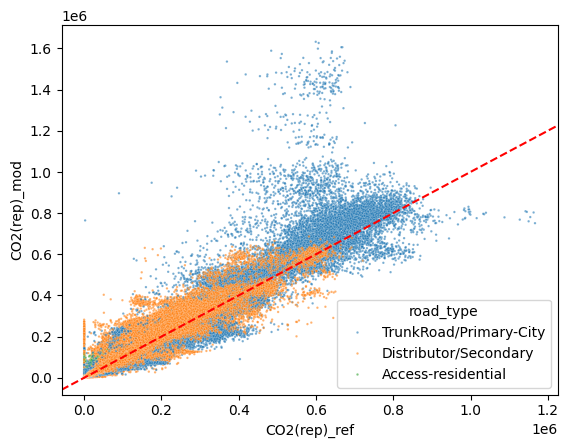

In [415]:
# plot uncertainty for all road links
sns.scatterplot(data = plot_df, x = f'{component}_ref', y = f'{component}_mod', s = 3, alpha = 0.6, hue = 'road_type')
plt.axline([0,0], [1,1], color = 'red', linestyle = '--')

-1.665940414300569
0.554080774781781


<Axes: xlabel='rel_diff', ylabel='Count'>

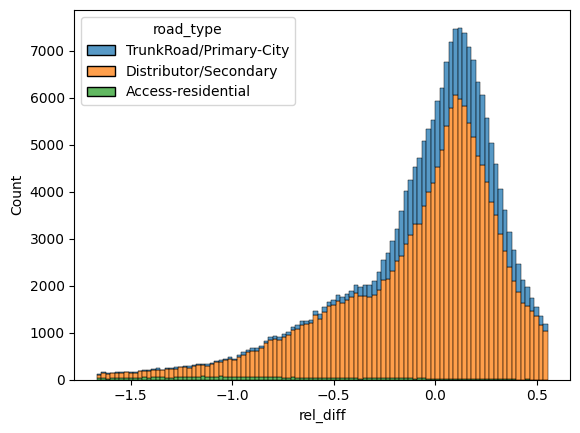

In [422]:
lb = np.percentile(plot_df['rel_diff'].to_numpy(), 2.5)
ub = np.percentile(plot_df['rel_diff'].to_numpy(), 97.5)

print(lb)
print(ub)

data = plot_df[['rel_diff', 'road_type']]
sns.histplot(data, x='rel_diff',  binrange= (lb,ub), bins= 100, multiple='stack', hue = 'road_type')

<Axes: xlabel='diff_rel', ylabel='Density'>

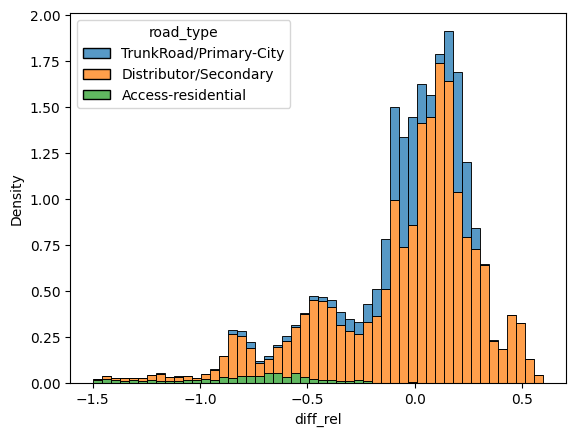

In [417]:
df_2 = plot_df.set_index('timestamp').groupby('road_link_id').resample('1d')[f'{component}_ref',f'{component}_mod'].sum().reset_index()
df_2['diff'] = df_2[f'{component}_ref'] - df_2[f'{component}_mod']
df_2['diff_rel'] = df_2['diff'] / df_2[f'{component}_ref']
#df_2['day_type'] = df_2['timestamp'].apply(cal.get_day_type_combined)
df_2['day_type'] = df_2['timestamp'].apply(cal.get_weekday)
df_2['road_type'] = df_2['road_link_id'].map(visum_links.set_index('road_link_id')['road_type'].to_dict())

sns.histplot(data = df_2, x = 'diff_rel', binrange= (-1.5,0.6), bins= 50, multiple= 'stack', hue = 'road_type', stat = 'density')

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 167
    # data points      = 100
    # variables        = 4
    chi-square         = 17663115.1
    reduced chi-square = 183990.782
    Akaike info crit   = 1216.18189
    Bayesian info crit = 1226.60258
    R-squared          = 0.96247987
[[Variables]]
    amplitude:  4460.21295 +/- 78.8945623 (1.77%) (init = 10)
    center:     0.33737776 +/- 0.00774275 (2.29%) (init = 0)
    sigma:      0.45190470 +/- 0.01339712 (2.96%) (init = 1)
    gamma:     -3.26169769 +/- 0.33935021 (10.40%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = +0.7482
    C(sigma, gamma)      = -0.7041
    C(center, gamma)     = -0.6038
    C(amplitude, sigma)  = +0.4391
    C(amplitude, center) = +0.2856


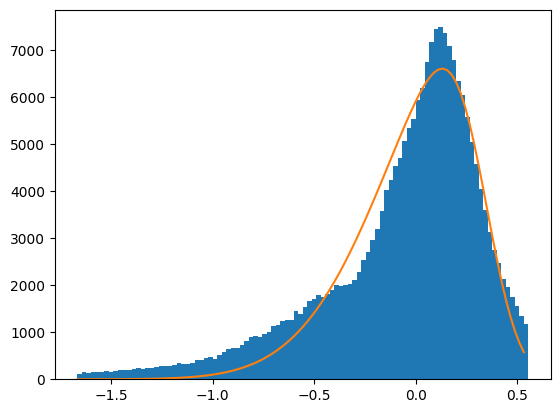

In [418]:
lb = np.percentile(plot_df['rel_diff'].to_numpy(), 2.5)
ub = np.percentile(plot_df['rel_diff'].to_numpy(), 97.5)

data = plot_df['rel_diff']
counts, bins, patche = plt.hist(data, range = (lb,ub), bins= 100)

x_values = bins[:-1]  # Take all but the last bin edge
y_values = counts

model = SkewedGaussianModel()

# set initial parameter values
params = model.make_params(amplitude=10, center=0, sigma=1, gamma=0)

# adjust parameters  to best fit data.
result = model.fit(y_values, params, x=x_values)

print(result.fit_report())
plt.plot(x_values, result.best_fit) 

[[Model]]
    (Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 187
    # data points      = 100
    # variables        = 6
    chi-square         = 2677345.06
    reduced chi-square = 28482.3943
    Akaike info crit   = 1031.51660
    Bayesian info crit = 1047.14762
    R-squared          = 0.99730435
[[Variables]]
    p1_amplitude:  4380.93754 +/- 135.416425 (3.09%) (init = 1)
    p1_center:    -0.14545802 +/- 0.01599558 (11.00%) (init = 0)
    p1_sigma:      0.51130583 +/- 0.01034230 (2.02%) (init = 1)
    p2_amplitude:  3556.99694 +/- 102.640612 (2.89%) (init = 1)
    p2_center:     0.10659436 +/- 0.00218203 (2.05%) (init = 0)
    p2_sigma:      0.16887286 +/- 0.00296388 (1.76%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(p1_amplitude, p2_amplitude) = -0.8890
    C(p2_amplitude, p2_sigma)     = +0.8864
    C(p1_center, p2_amplitude)    = -0.8349
    C(p1_amplitude,

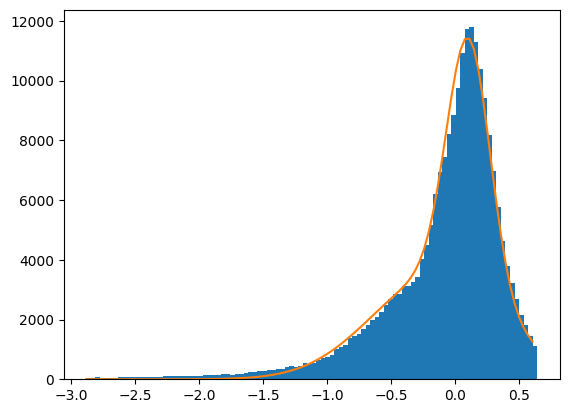

In [419]:
lb = np.percentile(plot_df['rel_diff'].to_numpy(), 1)
ub = np.percentile(plot_df['rel_diff'].to_numpy(), 99)

data = plot_df['rel_diff']
counts, bins, patche = plt.hist(data, range = (lb,ub), bins= 100)

x_values = bins[:-1]  # Take all but the last bin edge
y_values = counts

gmodel = Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')

params = gmodel.make_params(p1_amp=0.1, p1_cen=x_values.mean(), p1_wid=0.005,
                            p2_amp=0.5, p2_cen=x_values.mean(), p2_wid=0.005)

# adjust parameters  to best fit data
result = gmodel.fit(y_values, params, x=x_values)

print(result.fit_report())
plt.plot(x_values, result.best_fit) 

In [420]:
total_diff = plot_df.groupby('road_link_id')[[f'{component}_ref', f'{component}_mod']].sum().reset_index()
total_diff = total_diff[total_diff['road_link_id'].isin(valid_road_links)]

total_diff['diff'] = total_diff[f'{component}_ref'] - total_diff[f'{component}_mod']
total_diff['diff_rel'] = total_diff['diff'] /total_diff[f'{component}_ref']

Lower bound: -94.5244 %
Upper bound: 35.3474 %


<Axes: >

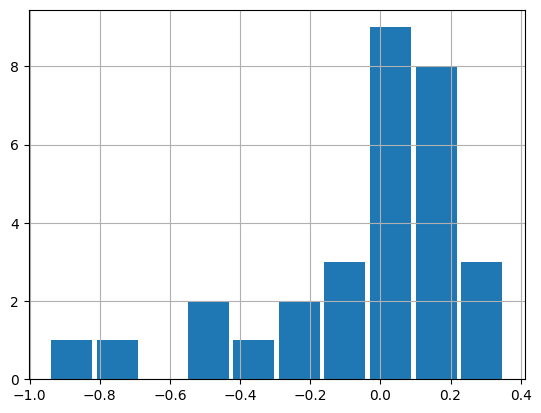

In [421]:
lb = np.percentile(total_diff['diff_rel'].to_numpy(), 2.5)
ub = np.percentile(total_diff['diff_rel'].to_numpy(), 97.5)

print(f'Lower bound: {(lb * 100):.4f} %')
print(f'Upper bound: {(ub * 100):.4f} %')

total_diff['diff_rel'].hist(range = (lb,ub), bins= 10, rwidth = 0.9)

In [427]:
for i in valid_road_links: 
    print(int(i))

38
72
419
810
1068
9655
12138
12350
12418
12496
12504
12681
12889
12895
12986
13176
13587
13682
16025
18241
46735
47391
47985
80236
80239
80609
52804339
52804341
52808787
52813283
52816773
52822574
53193449
67624481
541999239
554348450
562771968
562782535
562819026
576278854
590474952
591306500
591835523
594366323
594504783
594589400
594995477
595761758
595969067
704307987
878993750
893592578
894382578
895124133
899716943
900664568
2147483452
